### This notebook serves to compare the results of our different architectures on this cell nuclei segmentation task.

In [1]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd
import time

import matplotlib.pyplot as plt
import io
import pickle
import json

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T
import torch.nn.functional as F

from uNetModel import *
from encoder import *
from Unet_pretrained import *
from DeeperUnet import *
from LayerNormUnet import *
from GroupNormUnet import *

In [2]:
# For this cell used same code from PyTorch notebook in assignment 2 of Stanford's CS231n Spring 2018 offering
preprocessData = False # To preprocess data set this to True
USE_GPU = True
dtype = torch.float32
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    dtype = torch.float32

# Constant to control how frequently we print train loss
print_every = 1

print('using device:', device)

using device: cuda


In [4]:
# Opening up json file that contains preprocessed images
with open('processedData.json') as f:
    data = json.load(f)

X_train = np.array(data['X_train'])
Y_train = np.array(data['Y_train'])
X_val = np.array(data['X_val'])
Y_val = np.array(data['Y_val'])
X_test = np.array(data['X_test'])
Y_test = np.array(data['Y_test'])

print('Shape of X_train = ', X_train.shape)
print('Shape of Y_train = ', Y_train.shape)
print('Shape of X_val = ', X_val.shape)
print('Shape of Y_val = ', Y_val.shape)
print('Shape of X_test = ', X_test.shape)
print('Shape of Y_test = ', Y_test.shape)

Shape of X_train =  (402, 3, 128, 128)
Shape of Y_train =  (402, 1, 128, 128)
Shape of X_val =  (134, 3, 128, 128)
Shape of Y_val =  (134, 1, 128, 128)
Shape of X_test =  (134, 3, 128, 128)
Shape of Y_test =  (134, 1, 128, 128)


In [20]:
def showVisualComparisons(y, pred):
    y_reshaped = np.transpose(y, (1,2,0))
    pred_reshaped = np.transpose(pred, (1,2,0))
    imshow(np.squeeze(np.uint8(y_reshaped)))
    plt.title('Actual')
    plt.show()
    imshow(np.squeeze(np.uint8(pred_reshaped)))
    plt.title('Predicted')
    plt.show()

In [19]:
def showErrorMap(y, pred):
    y_reshaped = np.squeeze(np.transpose(y, (1,2,0)))
    pred_reshaped = np.squeeze(np.transpose(pred, (1,2,0)))
    error = (pred_reshaped != y_reshaped)
    imshow(np.uint8(error))
    plt.title('Error Map')
    plt.show()

In [14]:
def calculatePerformance(X_perf, Y_perf, model, mini_batch_size =  64, visual = False):
    D = 1
    for i in range(len(Y_perf.shape)):
        D *= Y_perf.shape[i]
    model.eval() #set model to evaluation mode
    numCorrect = 0
    num_batches = int(X_perf.shape[0]/mini_batch_size)
    num_remaining = X_perf.shape[0] - num_batches *mini_batch_size
    with torch.no_grad():
        for i in range(num_batches):
            x = torch.from_numpy(X_perf[i*mini_batch_size:(i+1)*mini_batch_size, :, :, :])
            y = torch.from_numpy(Y_perf[i*mini_batch_size:(i+1)*mini_batch_size, :, :, :]).type(torch.cuda.FloatTensor)
            x = x.to(device = device, dtype = dtype)
            preds = model(x)
            preds = (preds > 0.5).type(preds.type())
            numCorrect += (preds==y).sum()
        x = torch.from_numpy(X_perf[num_batches*mini_batch_size:, :, :, :])
        y = torch.from_numpy(Y_perf[num_batches*mini_batch_size:, :, :, :]).type(torch.cuda.FloatTensor)
        x = x.to(device = device, dtype = dtype)
        preds = model(x)
        preds = (preds > 0.5).type(preds.type())
        if visual:
            ix = np.random.randint((num_batches*mini_batch_size), X_perf.shape[0])
            showVisualComparisons(Y_perf[ix, :, :, :], preds[(ix - (num_batches*mini_batch_size)), :, :, :].cpu().numpy())
            showErrorMap(Y_perf[ix, :, :, :], preds[(ix - (num_batches*mini_batch_size)), :, :, :].cpu().numpy())
        numCorrect += (preds==y).sum()
    return float(numCorrect)/float(D)

In [15]:
def calc_iou(preds, y):
    preds = preds.view(preds.shape[0], -1)
    y = y.view(y.shape[0], -1)
    intersection = (y*preds.type(torch.float)).sum()
    union = y.sum() + (preds.type(torch.float)).sum() - intersection
    return (intersection/(union))

In [16]:
def calculatePerformanceIOU(X_perf, Y_perf, model, mini_batch_size =  64,visual = False):
    model.eval() #set model to evaluation mode
    mean_iou = 0
    num_batches = int(len(X_perf)/mini_batch_size)
    num_remaining = len(X_perf) - num_batches *mini_batch_size
    with torch.no_grad():
        for i in range(num_batches):
            x = torch.from_numpy(X_perf[i*mini_batch_size:(i+1)*mini_batch_size, :, :, :])
            y = torch.from_numpy(Y_perf[i*mini_batch_size:(i+1)*mini_batch_size, :, :, :])
            x = x.to(device = device, dtype = dtype)
            y = y.to(device = device, dtype = dtype)
            preds = model(x)
            preds = (preds > 0.5)
            mean_iou += float(mini_batch_size)*calc_iou(preds, y)
        x = torch.from_numpy(X_perf[num_batches*mini_batch_size:, :, :, :])
        y = torch.from_numpy(Y_perf[num_batches*mini_batch_size:, :, :, :])
        x = x.to(device = device, dtype = dtype)
        y = y.to(device = device, dtype = dtype)
        preds = model(x)
        preds = (preds > 0.5)
        if visual:
            ix = np.random.randint((num_batches*mini_batch_size), X_perf.shape[0])
            showVisualComparisons(Y_perf[ix, :, :, :], preds[(ix - (num_batches*mini_batch_size)), :, :, :].cpu().numpy())
            showErrorMap(Y_perf[ix, :, :, :], preds[(ix - (num_batches*mini_batch_size)), :, :, :].cpu().numpy())
        mean_iou += float(num_remaining)*calc_iou(preds, y)
    return (mean_iou/(float(X_perf.shape[0])))

The following are results from different UNets trained with BCE loss.
Mean IOU on train set ( bestDeepUNet ) =  0.8407729
Mean IOU on val set ( bestDeepUNet ) =  0.8064636
Mean IOU on test set ( bestDeepUNet ) =  0.81534696
Percent pixels correct on train set ( bestDeepUNet ) =  0.9734424192513993
Percent pixels correct on val set ( bestDeepUNet ) =  0.9662553018598414


/home/shared/anaconda3/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
/home/shared/anaconda3/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:74: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


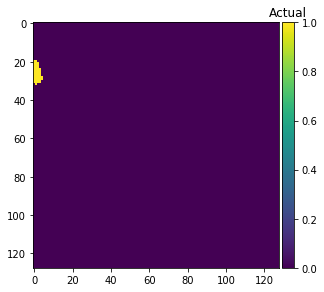

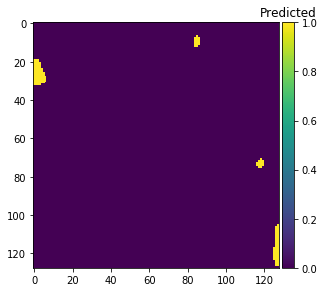

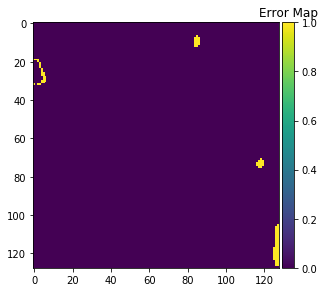

Percent pixels correct on test set ( bestDeepUNet ) =  0.9725264364214086
Mean IOU on train set ( bestTransferUNet ) =  0.84849954
Mean IOU on val set ( bestTransferUNet ) =  0.80758125
Mean IOU on test set ( bestTransferUNet ) =  0.8264334
Percent pixels correct on train set ( bestTransferUNet ) =  0.9741531296155939
Percent pixels correct on val set ( bestTransferUNet ) =  0.9652245364972015


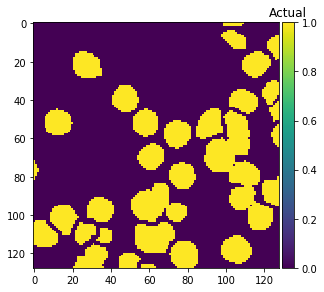

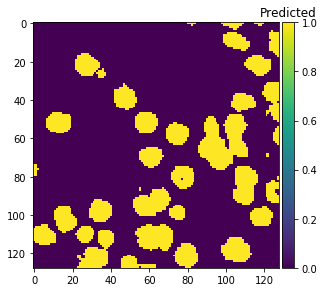

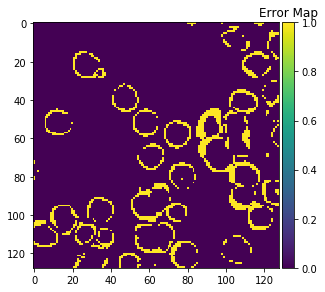

Percent pixels correct on test set ( bestTransferUNet ) =  0.9735991065181903
Mean IOU on train set ( bestGroupNormUNet ) =  0.8369563
Mean IOU on val set ( bestGroupNormUNet ) =  0.7761139
Mean IOU on test set ( bestGroupNormUNet ) =  0.8214655
Percent pixels correct on train set ( bestGroupNormUNet ) =  0.9719236762962531
Percent pixels correct on val set ( bestGroupNormUNet ) =  0.9596398197003265


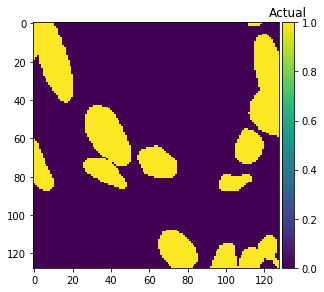

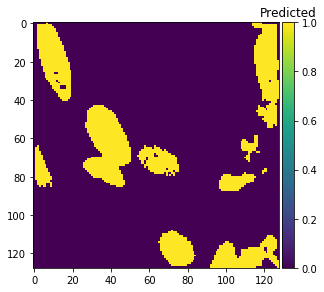

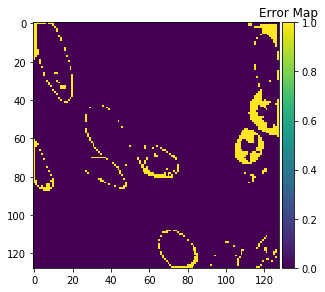

Percent pixels correct on test set ( bestGroupNormUNet ) =  0.9726457738164646
Mean IOU on train set ( bestLayerNormUNet ) =  0.92692184
Mean IOU on val set ( bestLayerNormUNet ) =  0.73098737
Mean IOU on test set ( bestLayerNormUNet ) =  0.7589314
Percent pixels correct on train set ( bestLayerNormUNet ) =  0.9882000216204135
Percent pixels correct on val set ( bestLayerNormUNet ) =  0.9510866990729944


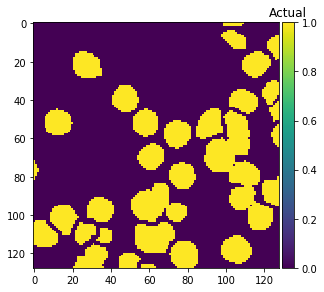

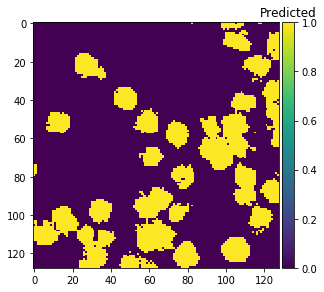

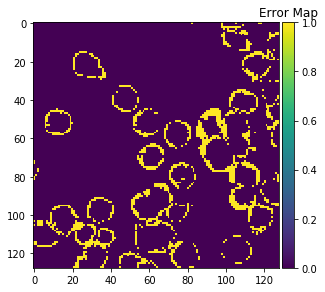

Percent pixels correct on test set ( bestLayerNormUNet ) =  0.96240234375
Mean IOU on train set ( bestBaselineUNet ) =  0.84186184
Mean IOU on val set ( bestBaselineUNet ) =  0.79953855
Mean IOU on test set ( bestBaselineUNet ) =  0.81294656
Percent pixels correct on train set ( bestBaselineUNet ) =  0.9731689756782493
Percent pixels correct on val set ( bestBaselineUNet ) =  0.9645909551364272


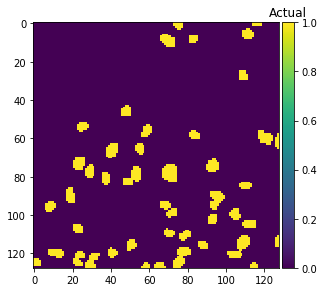

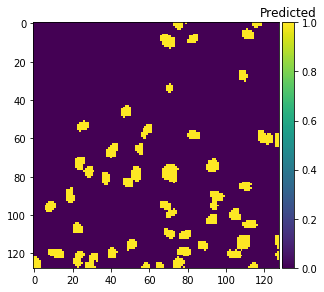

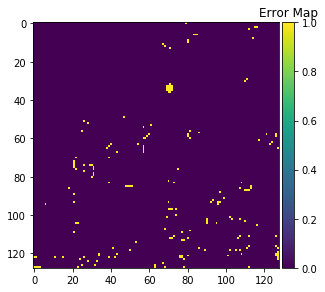

Percent pixels correct on test set ( bestBaselineUNet ) =  0.9715421306553171


In [21]:
print('The following are results from different UNets trained with BCE loss.')
modelNames = ['bestDeepUNet','bestTransferUNet','bestGroupNormUNet','bestLayerNormUNet', 'bestBaselineUNet']
for modelName in modelNames:
    model = torch.load(modelName)
    print('Mean IOU on train set (', modelName, ') = ', calculatePerformanceIOU(X_train, Y_train, model, visual = False).cpu().numpy())
    print('Mean IOU on val set (', modelName, ') = ', calculatePerformanceIOU(X_val, Y_val, model, visual = False).cpu().numpy())
    print('Mean IOU on test set (', modelName, ') = ', calculatePerformanceIOU(X_test, Y_test, model, visual = False).cpu().numpy())
    print('Percent pixels correct on train set (', modelName, ') = ', calculatePerformance(X_train, Y_train, model, visual = False))
    print('Percent pixels correct on val set (', modelName, ') = ', calculatePerformance(X_val, Y_val, model, visual = False))
    print('Percent pixels correct on test set (', modelName, ') = ', calculatePerformance(X_test, Y_test, model, visual = True))


The following is the result of training the baseline model with dice loss instead of BCE Loss
Mean IOU on train set (UNet trained with Dice loss) =  0.8490938
Mean IOU on val set (UNet trained with Dice loss) =  0.8169488
Mean IOU on test set (UNet trained with Dice loss) =  0.8262088
Percent pixels correct on train set (UNet trained with Dice loss) =  0.9747344818874378
Percent pixels correct on val set (UNet trained with Dice loss) =  0.9680617602903452


/home/shared/anaconda3/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
/home/shared/anaconda3/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:74: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


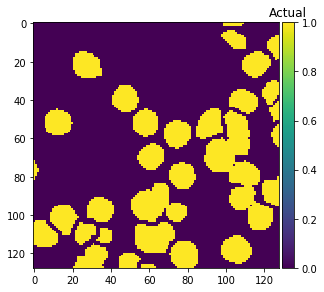

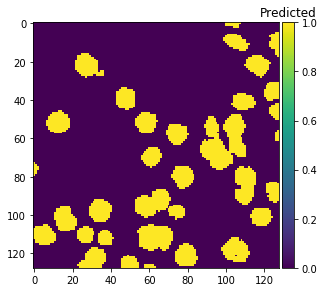

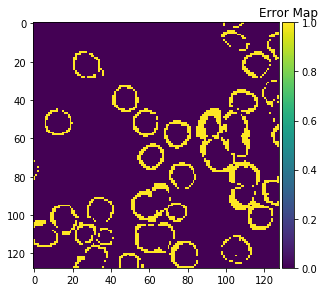

Percent pixels correct on test set (UNet trained with Dice loss) =  0.974143412575793


In [22]:
print('The following is the result of training the baseline model with dice loss instead of BCE Loss')
DiceModel = torch.load('bestDiceLossUNet')
print('Mean IOU on train set (UNet trained with Dice loss) = ', calculatePerformanceIOU(X_train, Y_train, DiceModel, visual = False).cpu().numpy())
print('Mean IOU on val set (UNet trained with Dice loss) = ', calculatePerformanceIOU(X_val, Y_val, DiceModel, visual = False).cpu().numpy())
print('Mean IOU on test set (UNet trained with Dice loss) = ', calculatePerformanceIOU(X_test, Y_test, DiceModel, visual = False).cpu().numpy())
print('Percent pixels correct on train set (UNet trained with Dice loss) = ', calculatePerformance(X_train, Y_train, DiceModel, visual = False))
print('Percent pixels correct on val set (UNet trained with Dice loss) = ', calculatePerformance(X_val, Y_val, DiceModel, visual = False))
print('Percent pixels correct on test set (UNet trained with Dice loss) = ', calculatePerformance(X_test, Y_test, DiceModel, visual = True))

# References
[1] Amdal-Saevik, K. (2018). Keras U-Net starter - LB 0.277. 
https://www.kaggle.com/keegil/keras-u-net-starter-lb-0-277?scriptVersionId=2164855/code

[2] Ho, D. J., Fu, C., Salama, P., Dunn, K. W., and Delp, E. J. (2017, July). Nuclei Segmentation of Fluorescence Microscopy Images Using Three Dimensional Convolutional Neural Networks. In Computer Vision and Pattern Recognition Workshops (CVPRW), 2017 IEEE Conference on (pp. 834-842). IEEE.

[3] Kakade, A., and Dumbali, J. (2018, February). Identification of nerve in ultrasound images using U-net architecture. In 2018 International Conference on Communication information and Computing Technology (ICCICT) (pp. 1-6). IEEE.

[4] Li, X., Chen, H., Qi, X., Dou, Q., Fu, C. W., and Heng, P. A. (2017). H-DenseUNet: Hybrid densely connected UNet for liver and liver tumor segmentation from CT volumes. arXiv preprint arXiv:1709.07330.

[5] Ronneberger, O., Fischer, P., and Brox, T. 
(2015, October). U-net: Convolutional networks for biomedical image segmentation. In International Conference on Medical image computing and computer-assisted intervention (pp. 234-241). Springer, Cham.

[6] Pearce, C. Convolutional (2017). Neural Networks and the Analysis of Cancer Imagery.

[7] Imagenet. https://patrykchrabaszcz.github.io/Imagenet32/